In [269]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [279]:
class Node(): #Object representing a "leaf" of the tree
    def __init__(self,pos,length,points):
        points=np.asarray(points) #In case given as list
        self.pos=pos #Node classified by position of centre (x,y) and length of box
        self.length=length
        self.points=points #Points stored in node
        if len(points)<1: #For later purposes
            self.coords=None
        else:
            self.coords=points[:,:-1] #Coords stored in node
        
        if self.coords==None: #Store mass and center of mass for node. If no points, no mass.
            self.mass=None
            self.com=None
        else:
            totmass=np.sum(points[:,2]) #Sum of masses
            xcom=(np.sum(points[:,0]*points[:,2]))/totmass
            ycom=(np.sum(points[:,1]*points[:,2]))/totmass
            self.com=[xcom,ycom] #store center of mass
            self.mass=totmass #Store total mass held in that node, i.e. sum of all child masses if has children
        self.children=[]  #Children of node
        
        
class QuadTree(): #Object to hold tree itself
    def __init__(self,points,velocities,boxsize): #Initialize with points to put in and size of total grid
        points=np.asarray(points)
        self.points=points
        self.vel=velocities
        
        self.size=boxsize
        #centerx=(np.max(points[:,0])+np.min(points[:,0]))/2
        #centery=(np.max(points[:,1])+np.min(points[:,1]))/2
        centerx=0 #Center is assumed to be (0,0). Another option is to use the two lines above.
        centery=0
        self.root=Node([centerx,centery],boxsize,points) #root of tree, large node centered at middle of box
    
        
    def rootdiv(self):
        self.divide(self.root)
        
    def divide(self,node): #The creation of the tree, dividing the points up into nodes
        
        if len(node.points)<2: #or node.length<self.size/(2**14):
            return #If only one point, no need to keep dividing
        cx=node.pos[0] #Center line in x
        cy=node.pos[1] #Center line in y
        xlow=node.pos[0]-node.length/2 #Upper and lower boundaries of node
        xhigh=node.pos[0]+node.length/2
        ylow=node.pos[1]-node.length/2
        yhigh=node.pos[1]+node.length/2
        
        pts=self.PtsInChild(xlow,cx,ylow,cy,node.points,4) #Find pts in "Southwest"(SW) child-node
        newcenter=[node.pos[0]-node.length/4,node.pos[1]-node.length/4]
        SW=Node(newcenter,node.length/2,pts) #Create that node 
        self.divide(SW) #Recursively do this
        
        pts=self.PtsInChild(xlow,cx,cy,yhigh,node.points,1) #Repeat for 3 other child nodes
        newcenter=[node.pos[0]-node.length/4,node.pos[1]+node.length/4]
        NW=Node(newcenter,node.length/2,pts) 
        self.divide(NW) 
        
        pts=self.PtsInChild(cx,xhigh,ylow,cy,node.points,3) 
        newcenter=[node.pos[0]+node.length/4,node.pos[1]-node.length/4]
        SE=Node(newcenter,node.length/2,pts) 
        self.divide(SE) 
        
        pts=self.PtsInChild(cx,xhigh,cy,yhigh,node.points,2) 
        newcenter=[node.pos[0]+node.length/4,node.pos[1]+node.length/4]
        NE=Node(newcenter,node.length/2,pts) 
        self.divide(NE) 
        
        node.children=[SW,NW,SE,NE] #Store each nodes "children"-i.e. its branches
        
        
    def PtsInChild(self,xmin,xmax,ymin,ymax, points, region): #Check in what child-nodes points should go in to
        #region argument is used for points falling exactly on a boundary
        ChildPoints=[]
        if region==1:
            for pts in points:
                if pts[0]>=xmin and pts[0]<xmax and pts[1]>=ymin and pts[1]<=ymax:
                    ChildPoints.append(pts)
        elif region==2:
            for pts in points:
                if pts[0]>=xmin and pts[0]<=xmax and pts[1]>ymin and pts[1]<=ymax:
                    ChildPoints.append(pts)
        elif region==3:
            for pts in points:
                if pts[0]>xmin and pts[0]<=xmax and pts[1]>=ymin and pts[1]<=ymax:
                    ChildPoints.append(pts)
        elif region==4:
            for pts in points:
                if pts[0]>=xmin and pts[0]<=xmax and pts[1]>=ymin and pts[1]<ymax:
                    ChildPoints.append(pts)
        return ChildPoints
    
    def find_children(self,node): #Finda all children, grandchildren, great-grand.. etc. for a specified node
        if not node.children:
            return [node]
        else:
            children = []
            for child in node.children:
                children += (self.find_children(child))
        return children
    
    
    def find_usedpts(self,pt,theta,node): #Find what effective points and masses to use for force on a point "pt"
        
        if not node.children: #node.children is false as boolean if 0
            return [node]
        s=node.length
        d=np.sqrt((node.com[0]-pt[0])**2 + (node.com[1]-pt[1])**2)
        if (s/d)<theta: #Check condition for whether to use big node, threshold set by theta
            return [node]
        else:
            children = []
            for child in node.children:
                children += (self.find_usedpts(pt,theta,child))
        return children
        
        
        
        
    def graph(self): #Plot of the tree, showing all the nodes
        fig = plt.figure(figsize=(12, 8))
        plt.title("Quadtree")
        ax = fig.add_subplot(111)
        c = self.find_children(self.root)
        areas = set()
        for el in c:
            areas.add(el.length*el.length)
        for n in c:
            ax.add_patch(patches.Rectangle((n.pos[0]-n.length/2, n.pos[1]-n.length/2), n.length, n.length, fill=False))
        x = [point[0] for point in self.points]
        y = [point[1] for point in self.points]
        plt.plot(x, y, 'ro',markersize='2')
        plt.savefig("100Quad")
        plt.show()
        return
    
    def usedgraph(self,pt): #Same as graph, but showing the nodes used to calculate force on "pt"
        theta=0.8
        fig = plt.figure(figsize=(12, 8))
        plt.title("Quadtree")
        ax = fig.add_subplot(111)
        c = self.find_usedpts(pt,theta,self.root)
        areas = set()
        for el in c:
            areas.add(el.length*el.length)
        for n in c:
            ax.add_patch(patches.Rectangle((n.pos[0]-n.length/2, n.pos[1]-n.length/2), n.length, n.length, fill=False))
        x = [point[0] for point in self.points]
        y = [point[1] for point in self.points]
        plt.plot(x, y, 'ro',markersize='2')
        plt.savefig("100Used")
        plt.show()
        return
    
    def Verlet(self,pt,vel,step): #Leapfrog Integrator
        h=step #stepsize
        G=1 #G, usually 1
        x=pt[0]
        y=pt[1]
        vx=vel[0]
        vy=vel[1]
        ax=0
        ay=0
        used=self.find_usedpts(pt,0.5,self.root) #Find nodes to use for force calc
        for node in used: 
            if node.mass!=None and node.mass!=pt[2]: #Only use node if has mass 
                xdis=node.com[0]-x
                ydis=node.com[1]-y
                r=(xdis**2+ydis**2)**(1/2) 
                if r>1e-9: #Do not want particles to close to eachother interacting.
                    ax+=(Gp*node.mass*xdis)/((r**3)+0.01) #Gives total acceleration in x and y directions, with softening factor 
                    ay+=(Gp*node.mass*ydis)/((r**3)+0.01)
        vx+=(h/2)*ax #Update vx and vy at t+h/2
        vy+=(h/2)*ay
        xnew=x+h*vx #Update x and y at t+h
        ynew=y+h*vy
        
        ax=0
        ay=0
        for node in used: #Find accelerations again, now at t+h
            if node.mass!=None and node.mass!=pt[2]: 
                xdis=node.com[0]-xnew
                ydis=node.com[1]-ynew
                r=(xdis**2+ydis**2)**(1/2) 
                if r>1e-9:
                    ax+=(Gp*node.mass*xdis)/((r**3)+0.01) 
                    ay+=(Gp*node.mass*ydis)/((r**3)+0.01)
        vxnew=vx+(h/2)*ax
        vynew=vy+(h/2)*ay
        
        return [xnew,ynew,pt[2]],[vxnew,vynew] #Spit out evolved points and velocities
    
    def Euler(self,pt,vel,step): #Euler Integrator
        h=step
        x=pt[0]
        y=pt[1]
        vx=vel[0]
        vy=vel[1]
        xn = x+vx*h #Evolve x and y
        yn = y+vy*h
        used=self.find_usedpts(pt,0.5,self.root)
        for node in used:
            if node.mass!=None and node.mass!=pt[2]:
                xdis=node.com[0]-x
                ydis=node.com[1]-y
                r=(xdis**2+ydis**2)**(1/2)
                
                vx+=h*node.mass*xdis/(r**3) #Evolve vx and vy
                vy+=h*node.mass*ydis/(r**3) 
        return [xn,yn,pt[2]],[vx,vy]
    
    def Clear(self): #Kills the tree by deleting everything. For memory-saving
        del self.root.children[:]
        return
    
    
    def plot(self): #Plots position of points in tree. Not really used.
        fig = plt.figure(figsize=(12, 8))
        plt.title("Points")
        ax = fig.add_subplot(111)
        plt.xlim(-self.size/2,self.size/2)
        plt.ylim(-self.size/2,self.size/2)
        plt.plot(self.points[:,0],self.points[:,1],'ro',markersize='2')
        
        plt.show()

        
def evolve(time,tree): #Evolves the points in a tree ("tree") to some future time "time"
    step=time/10000 #Stepsize, is not optimized, could also be an input variable
    t=0
    KE=np.empty([10001]) #Energy & Ang.mom. storage used for Solar System
    Pot=np.empty([10001])
    AngMom=np.empty([10001])
    N=0
    while t<time:
        points=tree.points
        vels=tree.vel
        New_Points=np.empty([len(points),3]) #Temp arrays to hold evolved quantities
        New_Velocities=np.empty([len(vels),2])
        for i in range(len(points)):
            pt=points[i] 
            vel=vels[i]
            New_Points[i],New_Velocities[i]=tree.Verlet(pt,vel,step) #Update
        ]
        
        if N%100==0:
            print(N)
        
        t+=step
        tree.Clear() #Kill tree
        tree=QuadTree(New_Points,New_Velocities,tree.size) #Create new tree with updated points
        ##### Ang.Mom. and Energy. Not needed in general.
        KE[N]=0.5*np.sum(tree.points[:,2]*(tree.vel[:,0]**2 + tree.vel[:,1]**2))
        Pot[N]=-(tree.points[0][2])*np.sum(tree.points[1:,2]*(1/((tree.points[1:,0]**2 + tree.points[1:,1]**2)**(1/2))))
        for i in range(len(tree.points)):
            rad=[tree.points[i][0],tree.points[i][1]]
            AngMom[N]+=np.linalg.norm(np.cross(tree.points[i][:2],tree.points[i][2]*tree.vel[i]))
        #####
        N+=1
        tree.rootdiv()
    return tree,KE,Pot,AngMom  #Return evolved tree, other quantities not in general



def evolve_once(time,tree): #Evolves the tree one time step. Used for animations.
    step=time/2000
    points=tree.points
    vels=tree.vel
    New_Points=np.empty([len(points),3]) #Temp arrays to hold evolved quantities
    New_Velocities=np.empty([len(vels),2])
    for i in range(len(points)):
        pt=points[i] 
        vel=vels[i]
        New_Points[i],New_Velocities[i]=tree.Verlet(pt,vel,step) #Update
        
    tree.Clear() #Kill tree
    tree=QuadTree(New_Points,New_Velocities,tree.size) #Create new tree with updated points
    tree.rootdiv()
    return tree #Return evolved tree

def AnimateTree(time,tree): #Creates an animation of the points as they are evolving in time
    fig = plt.figure(figsize=(12,8))
    bound=tree.size/2
    ax = plt.axes(xlim=(-bound, bound), ylim=(-bound, bound))
    ax.set_facecolor('black') #Right now plotting on black bg - nice for galaxies
    global N
    N=0
    
    line, = ax.plot([], [], 'wo',markersize='2',animated=True)
    
    # initialization function: plot the background of each frame
    def init():
        line.set_data(tree.points[:,0],tree.points[:,1])
        return line,
    global newtree
    newtree=evolve_once(time,tree)
    # animation function.  This is called sequentially
    def animate(i):
        for j in range(2):
            global newtree
            newtree=evolve_once(time,newtree) #evolves the tree here, does it twice before plotting new frame
            
        global N
        if (N%10)==0:
            print(N)
        N+=1
        x = newtree.points[:,0]
        y = newtree.points[:,1]
        line.set_data(x,y)
        
        return line,

    # call the animator.  
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=1000)  
    
    FFwriter = animation.FFMpegWriter()
    anim.save('SolarSystem.mp4',writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'])
    return newtree #Returns tree in case want to continue stuff after evolving.

In [290]:
#For galaxy, use different system of units for convenience. (Dimensionsless code not that convenient for big galaxy)
M=(1.989e+30)
Tyear=31558118.4 #Time, second/sidereal yr
#R=50000*9.461e+15 #5 Ly
R=3.086e+16 #m/Pc
G=6.67408e-11 #Grav constant (SI)
T=5000000*Tyear
Gp=(G*M*T**2)/(R**3) #New G, in new unit system

print(Gp)

0.11246066239065222


In [291]:
#Weighted draw: Do a weighted draw of points in galaxy to initialize
pts=[]
vels=[]
def draw():
    return np.random.uniform(0.01,7.5)
for i in range(0,2500):
    r=draw()
    rand=draw()
    if rand<NBOP(r): #This function, defined below, determines the weight
        theta=np.random.uniform(0,2*np.pi) #Angle chosen uniformly
        x=r*np.cos(theta)
        y=r*np.sin(theta)
        
        v=(Gp*(1e+6)/r)**(1/2)
        vx=(y/r)*v #Velocities chosen to have circular motion
        vy=-(x/r)*v
        
        pts.append([x,y,1])
        vels.append([vx,vy])

pts.append([0,0,1e+6]) #Add a SMBH in the middle
vels.append([0,0])
print(len(pts))

1196


In [296]:
#Unweighted draw
pts=[]
vels=[]
for i in range(0,500):
    r=np.random.uniform(0.01,7.5)
    theta=np.random.uniform(0,2*np.pi)
    x=r*np.cos(theta)
    y=r*np.sin(theta)
    
    v=(Gp*(1e+6)/r)**(1/2)
    vx=(y/r)*v
    vy=-(x/r)*v
    
    pts.append([x,y,1])
    vels.append([vx,vy])

pts.append([0,0,1e+6])
vels.append([0,0])
print(len(pts))

501


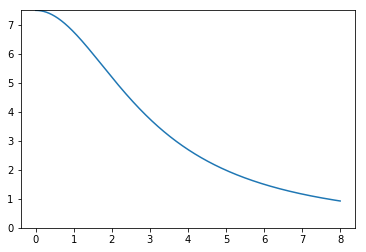

In [274]:
def NBOP(r): #Weighting function, used to create galaxy distributions. Resembles the pseudo-isothermal halo.
    return 7.5/(1+(r/3.0)**2) #+(0.1)*( -1/(1+(r/0.2)**2))
r=np.linspace(0,8,1000)

plt.plot(r,NBOP(r))
plt.ylim(0,7.5)
plt.show()

In [297]:
# Here some of the code is used in practice.


test=QuadTree(pts,vels,30)
test.rootdiv()
#NewTree,KE,Pot,L=evolve(10,test)
NewTree=AnimateTree(1,test)

#ts=time.time()
#Newtree,StoreE,StoreV=evolve(1,test)

#te=time.time()
#timeBF.append(te-ts)




/home/mats/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if sys.path[0] == '':
/home/mats/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if sys.path[0] == '':


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [61]:
#SOLARSYSTEM INITIALIZATION
R=152.1e+9 #distance, in m/semimajor axis
T=31558118.4 #Time, second/sidereal yr
G=6.67408e-11 #Grav constant
#Set G'=1 to get:
M=(R**3)/(G*(T**2))
MSun=(1.989e+30)/M
MEarth=(5.97e+24)/M
MVenus=0.815*MEarth
MMerc=0.0553*MEarth
MMars=0.107*MEarth
MJup=317.83*MEarth
MSat=95.16*MEarth
MUra=14.54*MEarth
MNep=17.15*MEarth
MMoon=0.0123*MEarth

EarthP=[(-1.496e+11)/R,0.0,MEarth]
VenusP=[(-1.082e+11)/R,0.0,MVenus]
MercP=[(-5.79e+10)/R,0.0,MMerc]
MarsP=[(-2.279e+11)/R,0.0,MMars]
JupP=[(-7.786e+11)/R,0.0,MJup]
SatP=[(-14.33e+11)/R,0.0,MSat]
UraP=[(-28.72e+11)/R,0.0,MUra]
NepP=[(-44.95e+11)/R,0.0,MNep]
SunP=[0.0,0.0,MSun]
MoonEx=-0.00384e+11
MoonP=[(MoonEx-1.496e+11)/R,0.0,MMoon]

MarsV=[0,24.1*((10**3)/R)*T]
MercV=[0,47.9*((10**3)/R)*T]
EarthV=[0,29.8*((10**3)/R)*T]
VenusV=[0,35.0*((10**3)/R)*T]
JupV=[0,13.1*((10**3)/R)*T]
SatV=[0,9.7*((10**3)/R)*T]
UraV=[0,6.8*((10**3)/R)*T]
NepV=[0,5.4*((10**3)/R)*T]
SunV=[0,0]
MoonV=[0,30.8*((10**3)/R)*T]

pts=[SunP,EarthP,VenusP,MarsP,MercP,MoonP,JupP,SatP,UraP,NepP]
vels=[SunV,EarthV,VenusV,MarsV,MercV,MoonV,JupV,SatV,UraV,NepV]
hey=np.asarray(pts)
print(vels)
print(pts)

[[0, 0], [0, 6.182984407100592], [0, 7.261894437869823], [0, 5.000333027218935], [0, 9.938421244970414], [0, 6.390467105325444], [0, 2.718023346745562], [0, 2.012582172781065], [0, 1.410882347928994], [0, 1.1204065704142012]]
[[0.0, 0.0, 37.5716918300395], [-0.9835634451019066, 0.0, 0.00011277174470856502], [-0.7113740959894806, 0.0, 9.190897193748048e-05], [-1.4983563445101906, 0.0, 1.2066576683816458e-05], [-0.3806706114398422, 0.0, 6.236277482383646e-06], [-0.9860880999342537, 0.0, 1.3870924599153498e-06], [-5.119000657462196, 0.0, 0.03584224362072322], [-9.421433267587114, 0.0, 0.010731359226467048], [-18.88231426692965, 0.0, 0.0016397011680625354], [-29.55292570677186, 0.0, 0.0019340354217518899]]


In [ ]:
#FOR SS, Different animator for nicer asthetics
def AnimateTree2(time,tree):
    fig = plt.figure(figsize=(12,8))
    bound=tree.size/2
    ax = plt.axes(xlim=(-bound, bound), ylim=(-bound, bound))
    global N
    N=0
    
    scat = ax.scatter([], [], s=[40,38,120,25,13,10,500,400,160,150],c=['g','k','y','r','r','c','#ed9524','#fac568','#3eeffa','#178b93'])
    
    # initialization function: plot the background of each frame
    def init():
        scat.set_offsets(np.c_[tree.points[:,0],tree.points[:,1]])
        return scat
    global newtree
    newtree=evolve_once(time,tree)
    # animation function.  This is called sequentially
    def animate(i):
        for j in range(5):
            global newtree
            newtree=evolve_once(time,newtree)
            
            #print(j,"  ",newtree.points[:,0])
        global N
        if (N%10)==0:
            print(N)
        N+=1
        x = newtree.points[:,0]
        y = newtree.points[:,1]
        #print("x: ",x)
        #print("y: ",y)
        #print(newtree.points)
        scat.set_offsets(np.c_[x,y])
        
        return scat

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=200)  #blit=True)
    
    FFwriter = animation.FFMpegWriter()
    anim.save('SolarSystem.mp4',writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'])
    return newtree